<a href="https://colab.research.google.com/github/kmonahan2/AdaptiveBackoff/blob/main/AdaptiveBackoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib gspread

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
# Open existing spreadsheet or create a new one
try:
    sh = gc.open('541_Sim_Results')  # Try to open the existing spreadsheet
except gspread.SpreadsheetNotFound:
    sh = gc.create('541_Sim_Results')  # Create a new one if not found

# Access the specific worksheet or create it
try:
    worksheet = sh.worksheet("Simulation Data")
except gspread.WorksheetNotFound:
    worksheet = sh.add_worksheet(title="Simulation Data", rows="100", cols="20")  # Create if it doesn't exist

# Access the "Theory" worksheet or create it if it doesn't exist
try:
    theory_worksheet = sh.worksheet("Theory")
except gspread.WorksheetNotFound:
    theory_worksheet = sh.add_worksheet(title="Theory", rows="100", cols="20")  # Adjust rows/cols as needed



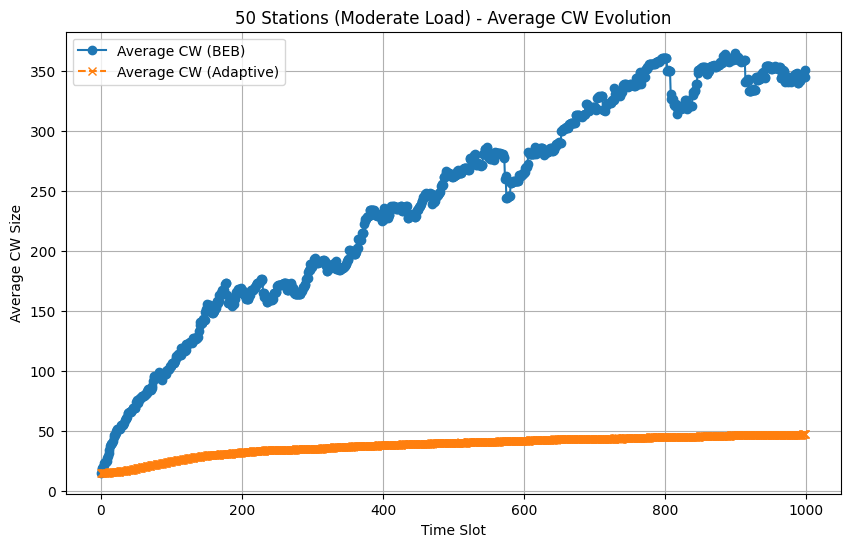

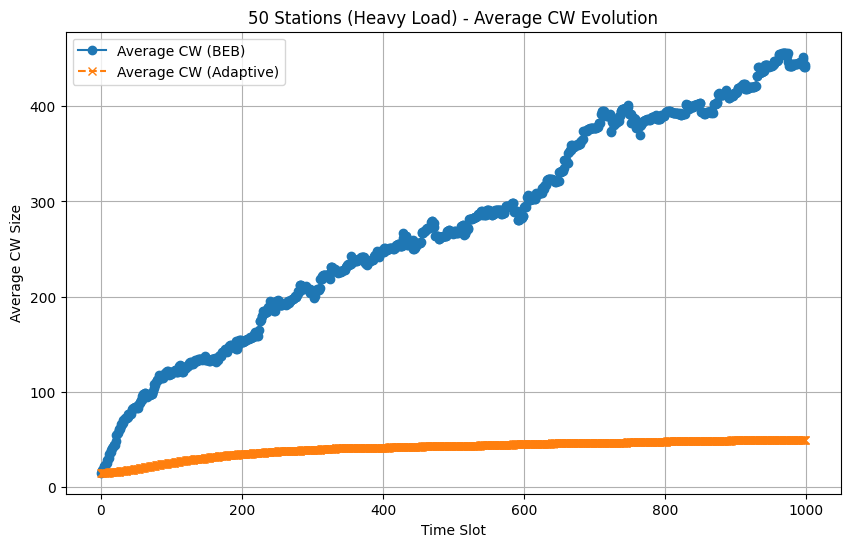

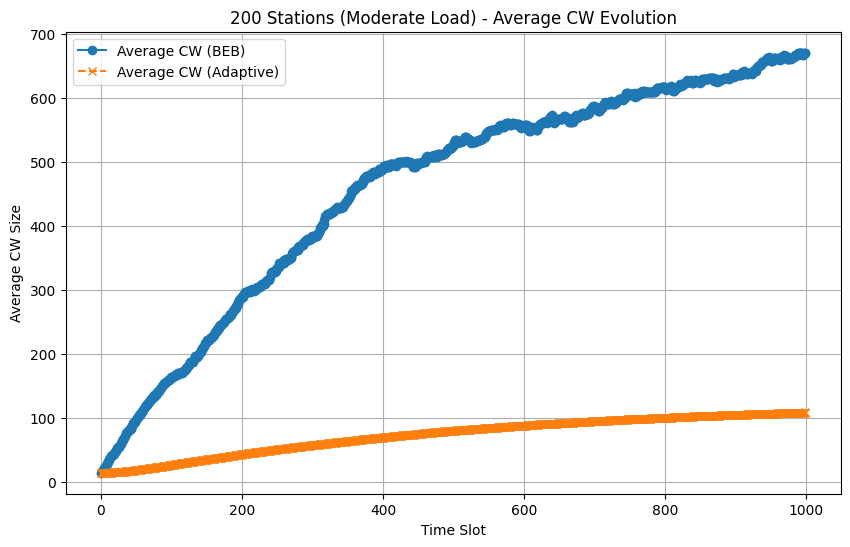

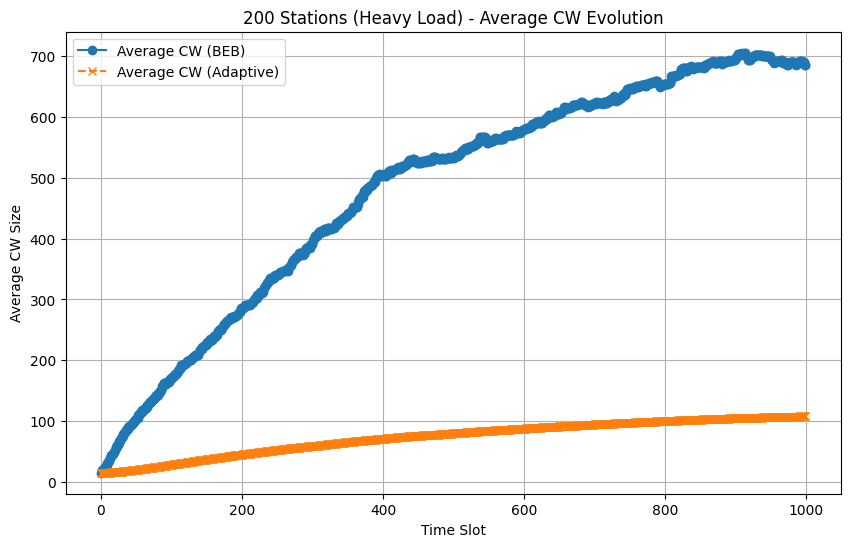

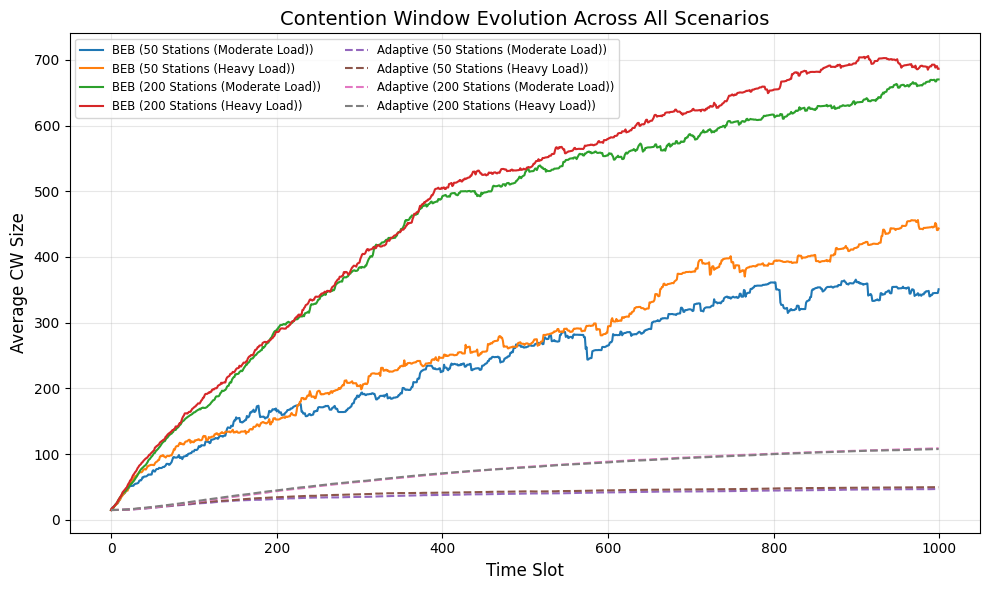

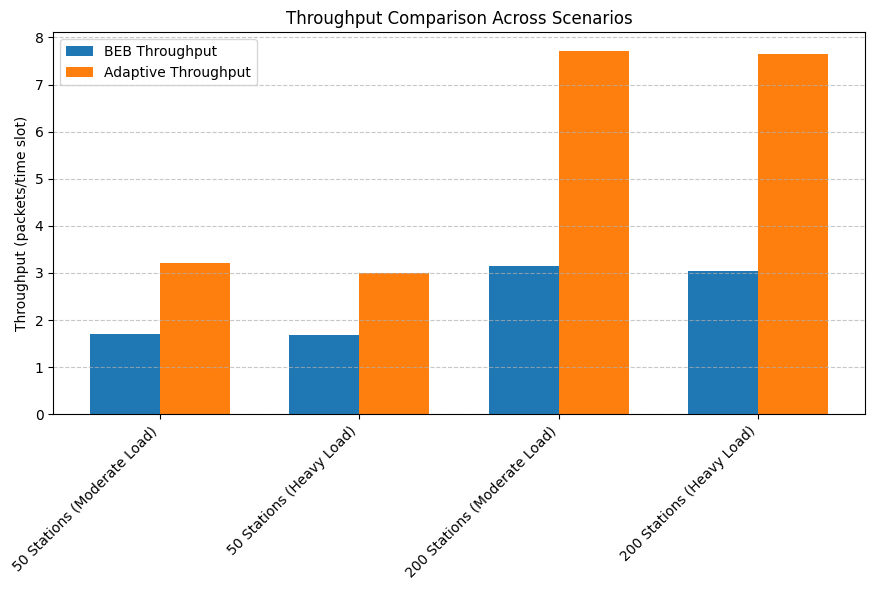

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Constants
SLOT_TIME = 20e-6
MAX_RETRIES = 10
CW_MIN_BASE = 15
CW_MAX_BASE = 1023
SIMULATION_DURATION = 1000
SERVICE_RATE = 1.2  # Adjusted μ for better handling of heavy loads
MAX_QUEUE_SIZE = 10  # Finite queue capacity

def random_backoff(CW):
    """Generate a random backoff value within the contention window."""
    return np.random.randint(0, CW)

def probabilistic_collision(CWs):
    """Simulate collisions as a Bernoulli process."""
    prob = calculate_collision_probability(CWs)
    return np.random.rand() < prob

def calculate_collision_probability(CWs):
    """
    Compute collision probability using the contention windows (CW).
    """
    if len(CWs) == 0:  # No active stations
        return 0

    # Calculate P_c using the theoretical formula
    collision_probability = 1 - np.prod([(1 - (1 / CW)) if CW > 0 else 0 for CW in CWs])
    return collision_probability


def calculate_metrics(queue_lengths, arrival_rate, service_rate, total_collisions, total_transmissions, packet_drops, packet_arrivals):
    """Calculate M/M/1/K queueing theory metric based on simulation results."""
    utilization = min(arrival_rate / service_rate, 1)  # Cap utilization at 1 for stability
    avg_queue_length = np.mean(queue_lengths) if len(queue_lengths) > 0 else 0
    avg_waiting_time = avg_queue_length / arrival_rate if arrival_rate > 0 else float('inf')
    avg_sojourn_time = avg_waiting_time + (1 / service_rate)
    collision_probability = total_collisions / total_transmissions if total_transmissions > 0 else 0
    packet_loss_rate = packet_drops / packet_arrivals if packet_arrivals > 0 else 0
    throughput = total_transmissions / SIMULATION_DURATION  # Packets per time slot

    return {
        "avg_queue_length": avg_queue_length,
        "utilization": utilization,
        "avg_waiting_time": avg_waiting_time,
        "avg_sojourn_time": avg_sojourn_time,
        "collision_probability": collision_probability,
        "packet_loss_rate": packet_loss_rate,
        "throughput": throughput,
    }

def theoretical_metrics(arrival_rate, service_rate, queue_capacity):
    """
    Compute theoretical metrics for an M/M/1/K queueing model.
    """
    rho = arrival_rate / service_rate
    p0 = (1 - rho) / (1 - rho ** (queue_capacity + 1))  # Probability of 0 packets in the system
    avg_queue_length = (rho / (1 - rho)) - ((queue_capacity + 1) * rho ** (queue_capacity + 1) / (1 - rho ** (queue_capacity + 1)))
    avg_waiting_time = avg_queue_length / arrival_rate if arrival_rate > 0 else float('inf')
    avg_sojourn_time = avg_waiting_time + (1 / service_rate)
    throughput = arrival_rate * (1 - (rho ** queue_capacity))  # Successful transmissions
    collision_probability = rho ** queue_capacity  # Proxy for dropped packets due to full queue

    return {
        "utilization": min(rho, 1),
        "avg_queue_length": avg_queue_length,
        "avg_waiting_time": avg_waiting_time,
        "avg_sojourn_time": avg_sojourn_time,
        "collision_probability": collision_probability,
        "throughput": throughput,
    }

def calculate_fairness_index(station_transmissions):
    """Calculate Jain's Fairness Index."""
    total_throughput = np.sum(station_transmissions)
    squared_throughput_sum = np.sum(station_transmissions**2)
    num_stations = len(station_transmissions)

    if total_throughput == 0 or num_stations == 0:
        return 0  # Avoid division by zero

    fairness_index = (total_throughput**2) / (num_stations * squared_throughput_sum)
    return fairness_index

def dcf_backoff(num_stations, network_load, arrival_rate):
    """Simulate traditional BEB with standard 802.11 backoff."""
    queue_lengths = np.zeros(num_stations)
    backoff_counts = [random_backoff(CW_MIN_BASE) for _ in range(num_stations)]
    retries = np.zeros(num_stations)
    total_transmissions = 0
    collisions = 0
    packet_drops = 0
    packet_arrivals = 0
    station_transmissions = np.zeros(num_stations)

    CWs = [CW_MIN_BASE] * num_stations
    cw_history = [[] for _ in range(num_stations)]  # To track CW evolution

    for attempt in range(SIMULATION_DURATION):
        for station in range(num_stations):
            if np.random.rand() < network_load:
                packet_arrivals += 1
                if queue_lengths[station] < MAX_QUEUE_SIZE:
                    queue_lengths[station] += np.random.poisson(arrival_rate)
                else:
                    packet_drops += 1

            if queue_lengths[station] > 0 and np.random.rand() < SERVICE_RATE:
                queue_lengths[station] -= 1

        for t in range(num_stations):
            cw_history[t].append(CWs[t])
            if backoff_counts[t] > 0:
                backoff_counts[t] -= 1

            if backoff_counts[t] == 0:
                total_transmissions += 1
                if probabilistic_collision(CWs):
                    collisions += 1
                    retries[t] += 1
                    CWs[t] = min(CWs[t] * 2, CW_MAX_BASE)
                    backoff_counts[t] = random_backoff(CWs[t])
                else:
                    retries[t] = 0
                    CWs[t] = CW_MIN_BASE
                    backoff_counts[t] = random_backoff(CWs[t])
                    station_transmissions[t] += 1

    return {
        "queue_lengths": queue_lengths,
        "collisions": collisions,
        "total_transmissions": total_transmissions,
        "packet_drops": packet_drops,
        "packet_arrivals": packet_arrivals,
        "station_transmissions": station_transmissions,
        "cw_history": cw_history,
    }

def adaptive_backoff(num_stations, network_load, arrival_rate, lam=2, mu=1, alpha=0.2, beta=0.1):
    """
    Adaptive backoff with queue-aware prioritization and dynamic CW adjustment.
    """
    queue_lengths = np.zeros(num_stations)
    backoff_counts = [random_backoff(CW_MIN_BASE) for _ in range(num_stations)]
    retries = np.zeros(num_stations)
    total_transmissions = 0
    collisions = 0
    packet_drops = 0
    packet_arrivals = 0
    station_transmissions = np.zeros(num_stations)

    CWs = [CW_MIN_BASE] * num_stations
    cw_history = [[] for _ in range(num_stations)]
    CW_min = CW_MIN_BASE
    CW_max = CW_MAX_BASE

    for attempt in range(SIMULATION_DURATION):
        # Compute channel conditions for each station
        channel_conditions = [np.random.uniform(0.7, 1.0) for _ in range(num_stations)]

        # Compute priorities for each station
        priorities = [
            lam * queue_lengths[t] + mu * channel_conditions[t]
            for t in range(num_stations)
        ]
        total_priority = sum(priorities)
        normalized_priorities = [
            (p / total_priority) if total_priority > 0 else (1 / num_stations)
            for p in priorities
        ]

        for station in range(num_stations):
            # Poisson packet arrivals
            if np.random.rand() < network_load:
                packet_arrivals += 1
                if queue_lengths[station] < MAX_QUEUE_SIZE:
                    queue_lengths[station] += np.random.poisson(arrival_rate)
                else:
                    packet_drops += 1

            # Priority-aware packet service
            priority_factor = normalized_priorities[station]
            effective_service_rate = SERVICE_RATE * (1 + priority_factor)
            if queue_lengths[station] > 0 and np.random.rand() < effective_service_rate:
                queue_lengths[station] -= 1

        for t in range(num_stations):
            cw_history[t].append(CWs[t])
            if backoff_counts[t] > 0:
                backoff_counts[t] -= 1

            if backoff_counts[t] == 0:
                total_transmissions += 1
                priority_factor = normalized_priorities[t]
                # Compute ∆ for CW adjustment
                delta = alpha * retries[t] + beta * queue_lengths[t]

                if probabilistic_collision(CWs):
                    collisions += 1
                    retries[t] += 1
                    CWs[t] = min(CWs[t] + delta, CW_max)  # On collision
                    backoff_counts[t] = random_backoff(CWs[t])
                else:
                    retries[t] = 0
                    CWs[t] = max(CWs[t] - delta, CW_min)  # On success
                    backoff_counts[t] = random_backoff(CWs[t])
                    station_transmissions[t] += 1

    return {
        "queue_lengths": queue_lengths,
        "collisions": collisions,
        "total_transmissions": total_transmissions,
        "packet_drops": packet_drops,
        "packet_arrivals": packet_arrivals,
        "station_transmissions": station_transmissions,
        "cw_history": cw_history,
    }

def simulate_and_compare(scenarios):
    beb_throughputs = []
    adaptive_throughputs = []
    scenario_labels = []
    comparison_table = []
    comparison_theory_table = []
    combined_beb_cw = []
    combined_adaptive_cw = []

    for scenario in scenarios:
        label = scenario['label']
        num_stations = scenario['num_stations']
        arrival_rate = scenario['arrival_rate']
        network_load = scenario['network_load']

        if arrival_rate >= SERVICE_RATE:
            print(f"Warning: Arrival rate ({arrival_rate}) exceeds service rate ({SERVICE_RATE}). Adjusting arrival rate.")
            arrival_rate = SERVICE_RATE * 0.9

        # Simulate DCF Backoff
        results_beb = dcf_backoff(num_stations, network_load, arrival_rate)
        metrics_beb = calculate_metrics(
            results_beb["queue_lengths"], arrival_rate, SERVICE_RATE,
            results_beb["collisions"], results_beb["total_transmissions"],
            results_beb["packet_drops"], results_beb["packet_arrivals"],
        )

        # Simulate Adaptive Backoff
        results_adaptive = adaptive_backoff(num_stations, network_load, arrival_rate)
        metrics_adaptive = calculate_metrics(
            results_adaptive["queue_lengths"], arrival_rate, SERVICE_RATE,
            results_adaptive["collisions"], results_adaptive["total_transmissions"],
            results_adaptive["packet_drops"], results_adaptive["packet_arrivals"],
        )

        # Calculate fairness index
        fairness_beb = calculate_fairness_index(results_beb["station_transmissions"])
        fairness_adaptive = calculate_fairness_index(results_adaptive["station_transmissions"])

        # Store throughput results for bar graph
        beb_throughputs.append(metrics_beb["throughput"])
        adaptive_throughputs.append(metrics_adaptive["throughput"])
        scenario_labels.append(label)

        # Append CW history for graphing
        combined_beb_cw.append((label, results_beb["cw_history"]))
        combined_adaptive_cw.append((label, results_adaptive["cw_history"]))


        # Calculate percentage differences
        percent_diff_queue = (
            abs(metrics_adaptive["avg_queue_length"] - metrics_beb["avg_queue_length"]) / metrics_beb["avg_queue_length"] * 100
            if metrics_beb["avg_queue_length"] > 0 else 0
        )
        percent_diff_utilization = (
            abs(metrics_adaptive["utilization"] - metrics_beb["utilization"]) / metrics_beb["utilization"] * 100
            if metrics_beb["utilization"] > 0 else 0
        )
        percent_diff_throughput = (
            abs(metrics_adaptive["throughput"] - metrics_beb["throughput"]) / metrics_beb["throughput"] * 100
            if metrics_beb["throughput"] > 0 else 0
        )
        percent_diff_collision = (
            abs(metrics_adaptive["collision_probability"] - metrics_beb["collision_probability"]) / metrics_beb["collision_probability"] * 100
            if metrics_beb["collision_probability"] > 0 else 0
        )


        # Append results to comparison table
        comparison_table.append({
            "Scenario": label,
            "BEB Fairness": fairness_beb,
            "Adaptive Fairness": fairness_adaptive,
            "BEB Avg Queue": metrics_beb["avg_queue_length"],
            "Adaptive Avg Queue": metrics_adaptive["avg_queue_length"],
            "% Diff Queue": percent_diff_queue,
            "BEB Utilization": metrics_beb["utilization"],
            "Adaptive Utilization": metrics_adaptive["utilization"],
            "% Diff Utilization": percent_diff_utilization,
            "BEB Throughput": metrics_beb["throughput"],
            "Adaptive Throughput": metrics_adaptive["throughput"],
            "% Diff Throughput": percent_diff_throughput,
            "BEB Collision Rate": metrics_beb["collision_probability"],
            "Adaptive Collision Rate": metrics_adaptive["collision_probability"],
            "Collision Rate % Diff": percent_diff_collision,
            "BEB Packet Loss": metrics_beb["packet_loss_rate"],
            "Adaptive Packet Loss": metrics_adaptive["packet_loss_rate"],
        })


        # Compute theoretical metrics
        theoretical_beb = theoretical_metrics(arrival_rate, SERVICE_RATE, MAX_QUEUE_SIZE)
        theoretical_adaptive = theoretical_metrics(arrival_rate, SERVICE_RATE, MAX_QUEUE_SIZE)

        # Compute differences between simulation and theoretical results
        comparison_results = {
            "Scenario": label,
            "BEB Avg Queue (Sim)": metrics_beb["avg_queue_length"],
            "BEB Avg Queue (Theory)": theoretical_beb["avg_queue_length"],
            "% Diff Avg Queue (BEB)": (
                abs(metrics_beb["avg_queue_length"] - theoretical_beb["avg_queue_length"]) / theoretical_beb["avg_queue_length"] * 100
                if theoretical_beb["avg_queue_length"] > 0 else 0
            ),
            "Adaptive Avg Queue (Sim)": metrics_adaptive["avg_queue_length"],
            "Adaptive Avg Queue (Theory)": theoretical_adaptive["avg_queue_length"],
            "% Diff Avg Queue (Adaptive)": (
                abs(metrics_adaptive["avg_queue_length"] - theoretical_adaptive["avg_queue_length"]) / theoretical_adaptive["avg_queue_length"] * 100
                if theoretical_adaptive["avg_queue_length"] > 0 else 0
            ),
            "BEB Throughput (Sim)": metrics_beb["throughput"],
            "BEB Throughput (Theory)": theoretical_beb["throughput"],
            "% Diff Throughput (BEB)": (
                abs(metrics_beb["throughput"] - theoretical_beb["throughput"]) / theoretical_beb["throughput"] * 100
                if theoretical_beb["throughput"] > 0 else 0
            ),
            "Adaptive Throughput (Sim)": metrics_adaptive["throughput"],
            "Adaptive Throughput (Theory)": theoretical_adaptive["throughput"],
            "% Diff Throughput (Adaptive)": (
                abs(metrics_adaptive["throughput"] - theoretical_adaptive["throughput"]) / theoretical_adaptive["throughput"] * 100
                if theoretical_adaptive["throughput"] > 0 else 0
            ),
        }

        # Append results to the theory worksheet
        comparison_theory_table.append(comparison_results)


        # Plot Avg CW evolution for both algorithms
        plt.figure(figsize=(10, 6))

        # Calculate and plot the average CW for BEB
        avg_cw_beb = [sum(slot) / len(slot) for slot in zip(*results_beb["cw_history"])]
        plt.plot(avg_cw_beb, label="Average CW (BEB)", linestyle='-', marker='o')

        # Calculate and plot the average CW for Adaptive
        avg_cw_adaptive = [sum(slot) / len(slot) for slot in zip(*results_adaptive["cw_history"])]
        plt.plot(avg_cw_adaptive, label="Average CW (Adaptive)", linestyle='--', marker='x')

        # Add title, labels, and legend
        plt.title(f"{label} - Average CW Evolution")
        plt.xlabel("Time Slot")
        plt.ylabel("Average CW Size")
        plt.legend()
        plt.grid()
        plt.show()

    plt.figure(figsize=(10, 6))
    # Plot CW history for BEB
    for label, cw_history in combined_beb_cw:
        avg_cw_beb = [sum(slot) / len(slot) for slot in zip(*cw_history)]
        plt.plot(avg_cw_beb, label=f"BEB ({label})", linestyle='-', linewidth=1.5)

    # Plot CW history for Adaptive
    for label, cw_history in combined_adaptive_cw:
        avg_cw_adaptive = [sum(slot) / len(slot) for slot in zip(*cw_history)]
        plt.plot(avg_cw_adaptive, label=f"Adaptive ({label})", linestyle='--', linewidth=1.5)

    # Add labels, title, legend, and grid
    plt.title("Contention Window Evolution Across All Scenarios", fontsize=14)
    plt.xlabel("Time Slot", fontsize=12)
    plt.ylabel("Average CW Size", fontsize=12)
    plt.legend(loc="upper left", fontsize='small', ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Write header only if the sheet is empty
    header = list(comparison_table[0].keys())
    if len(worksheet.get_all_values()) == 0:
        worksheet.append_row(header)
    else:
        worksheet.clear()
        worksheet.append_row(header)

    # Append new rows of data
    for row_data in comparison_table:
        worksheet.append_row(list(row_data.values()))

    # Write the comparison results to the "Theory" worksheet
    theory_header = list(comparison_theory_table[0].keys())
    if len(theory_worksheet.get_all_values()) == 0:
        theory_worksheet.append_row(theory_header)
    else:
        theory_worksheet.clear()
        theory_worksheet.append_row(theory_header)

    # Append new rows
    for row_data in comparison_theory_table:
        theory_worksheet.append_row(list(row_data.values()))

    # Throughput bar graph
    x = np.arange(len(scenario_labels))
    width = 0.35

    plt.figure(figsize=(9, 6))
    plt.bar(x - width / 2, beb_throughputs, width, label='BEB Throughput')
    plt.bar(x + width / 2, adaptive_throughputs, width, label='Adaptive Throughput')
    plt.xticks(x, scenario_labels, rotation=45, ha="right")
    plt.ylabel('Throughput (packets/time slot)')
    plt.title('Throughput Comparison Across Scenarios')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Define simulation scenarios for 50 and 200 stations
scenarios = [
    {"label": "50 Stations (Moderate Load)", "num_stations": 50, "arrival_rate": 0.5, "network_load": 0.7},
    {"label": "50 Stations (Heavy Load)", "num_stations": 50, "arrival_rate": 0.9, "network_load": 0.95},
    {"label": "200 Stations (Moderate Load)", "num_stations": 200, "arrival_rate": 0.5, "network_load": 0.7},
    {"label": "200 Stations (Heavy Load)", "num_stations": 200, "arrival_rate": 0.9, "network_load": 0.95},
]

# Run simulations
simulate_and_compare(scenarios)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
